# Create dummy system matrix

In [1]:
import numpy as np
from skimage.draw import polygon
import matplotlib.pyplot as plt

In [2]:
def get_rotated(xys: np.ndarray, center: np.ndarray, angle: float = 0) -> np.ndarray:
    angle = np.deg2rad(angle)
    xys_p = xys - center
    mr = np.array(
        [
            [np.cos(angle), -np.sin(angle)],
            [np.sin(angle), np.cos(angle)],
        ]
    )
    return np.matmul(mr, xys_p.T).T + center

def add_ppdf_strip(img: np.ndarray, b_s: int, b_e: int, angle: float, t_c: int = 0):
    """Summary line.

    Extended description of function.

    Parameters
    ----------
    img : numpy.ndarray
        Image template
    b_s : int
        shorter base
    b_e : int
        longer base
    t_c : int
        shorter base center. t_c is the x coordinate if angle = 0 degree
    angle: float
        rotation angle of the trapezoid in degrees
    
    Returns
    -------
    bool
        Description of return value

    """
    half = np.max(img.shape)//2
    poly_0 = np.array(
        (
            (t_c - 0.5 * b_s, -half),
            (t_c - 0.5 * b_e, half*3),
            (t_c + 0.5 * b_e, half*3),
            (t_c + 0.5 * b_s, -half),
        )
    )
    poly_rot = get_rotated(poly_0,np.array(img.shape)//2,angle)
    xx, yy = polygon(poly_rot[:, 0], poly_rot[:, 1], img.shape)
    img[xx, yy] = 1

In [3]:
img=np.zeros((200,200))
add_ppdf_strip(img,3,5,30,50)

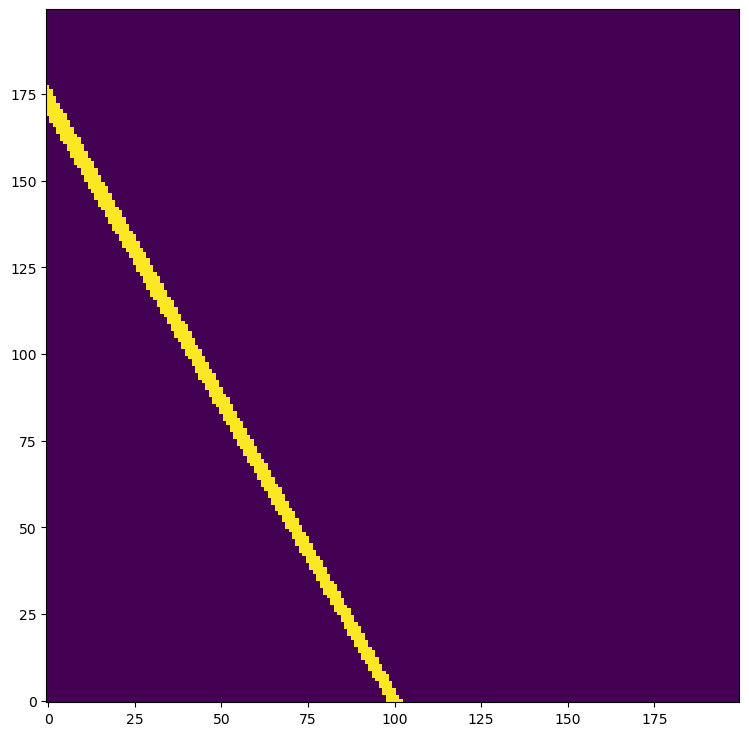

In [4]:
fig, ax = plt.subplots(figsize=(16,9))
ax.imshow(img.T,origin='lower')

## More strips

#### Dummy detector setup

- 39 detector units in 1 panel
- 36 panels surrounding the FOV in 360 degrees
- strips are generated as trapezoids with given longer and shorter bases
- strips are uniform for all detector units

In [45]:
N_angle = 36
N_tc = 39
step_tc = 10
dims=np.array((400,400))
sysmat= np.empty((N_angle, N_tc, dims[0],dims[1]))
for angle_idx in np.arange(N_angle):
    angle = angle_idx*360/N_angle
    # print(angle)
    for tc_idx in np.arange(N_tc):
        tc=(tc_idx+1)*step_tc
        img = np.zeros(dims)
        add_ppdf_strip(img,5,15,angle,tc)
        sysmat[angle_idx,tc_idx]=img

### One panel

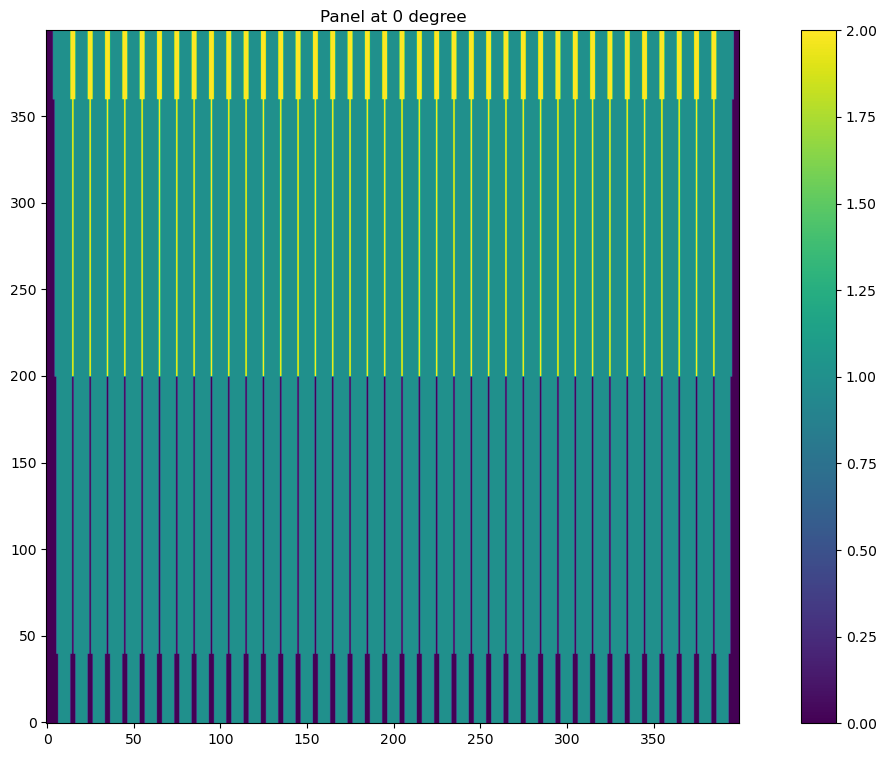

In [46]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("Panel at 0 degree")
fig.colorbar(ax.imshow(np.sum(sysmat[0],axis=(0)).T,origin='lower'))
del fig, ax

### Sensitivity

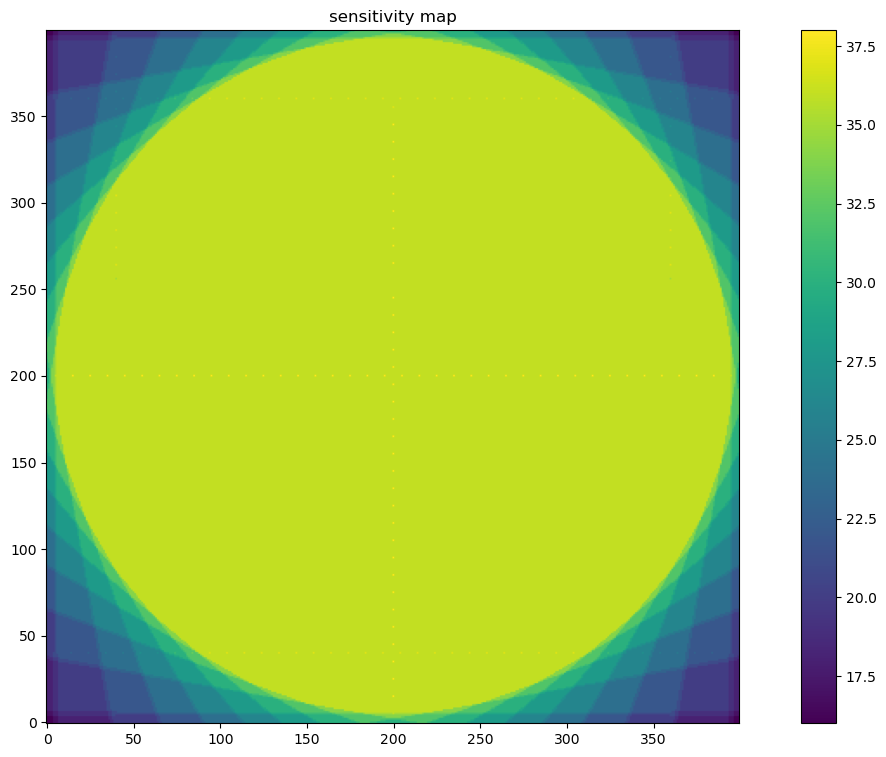

In [48]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("sensitivity map")
fig.colorbar(ax.imshow(np.sum(sysmat,axis=(0,1)).T,origin='lower')
del fig, ax

::: {.content-hidden}
### sampling angle max and min routine
:::

In [101]:
def sampling_angle(fov_dim: np.ndarray, b_s: int, b_e: int, angle: float, t_c: int = 0):
    """Calculate the sampling angle for the dummy sysmtem matrix

    Extended description of function.

    Parameters
    ----------
    fov_dim : numpy.ndarray
        Image FOV dimension, number of pixels
    b_s : int
        shorter base
    b_e : int
        longer base
    t_c : int
        shorter base center. t_c is the x coordinate if angle = 0 degree
    angle: float
        rotation angle of the trapezoid in degrees
    
    Returns
    -------
    numpy.ndarray
        maximum sampling angles of every fov pixels. It has the shape of fov_dim
    """
    half = np.max(fov_dim)//2
    front = np.array([
            (t_c - 0.5 * b_s, -half),
            (t_c + 0.5 * b_s, -half),
    ])
    front_rot = get_rotated(front,fov_dim//2,angle)
    xx, yy = np.meshgrid(np.arange(fov_dim[0]), np.arange(fov_dim[1]))
    ab0x = front_rot[0,0]-xx
    ab0y = front_rot[0,1]-yy
    ab1x = front_rot[1,0]-xx
    ab1y = front_rot[1,1]-yy
    # print(ab1x.shape,ab1y.shape,np.stack((ab0x,ab0y)).shape)
    deg_max = np.rad2deg(np.max(np.stack((np.arctan2(ab0y, ab0x),np.arctan2(ab1y, ab1x))),axis=0))
    deg_min = np.rad2deg(np.min(np.stack((np.arctan2(ab0y, ab0x),np.arctan2(ab1y, ab1x))),axis=0))
    return deg_max%360 ,deg_min%360
    

### test of the routine with a dummy detector unit @ (200, -200)

In [102]:
max_angle, min_angle = sampling_angle(np.array([400,400]),5,15,0,200)

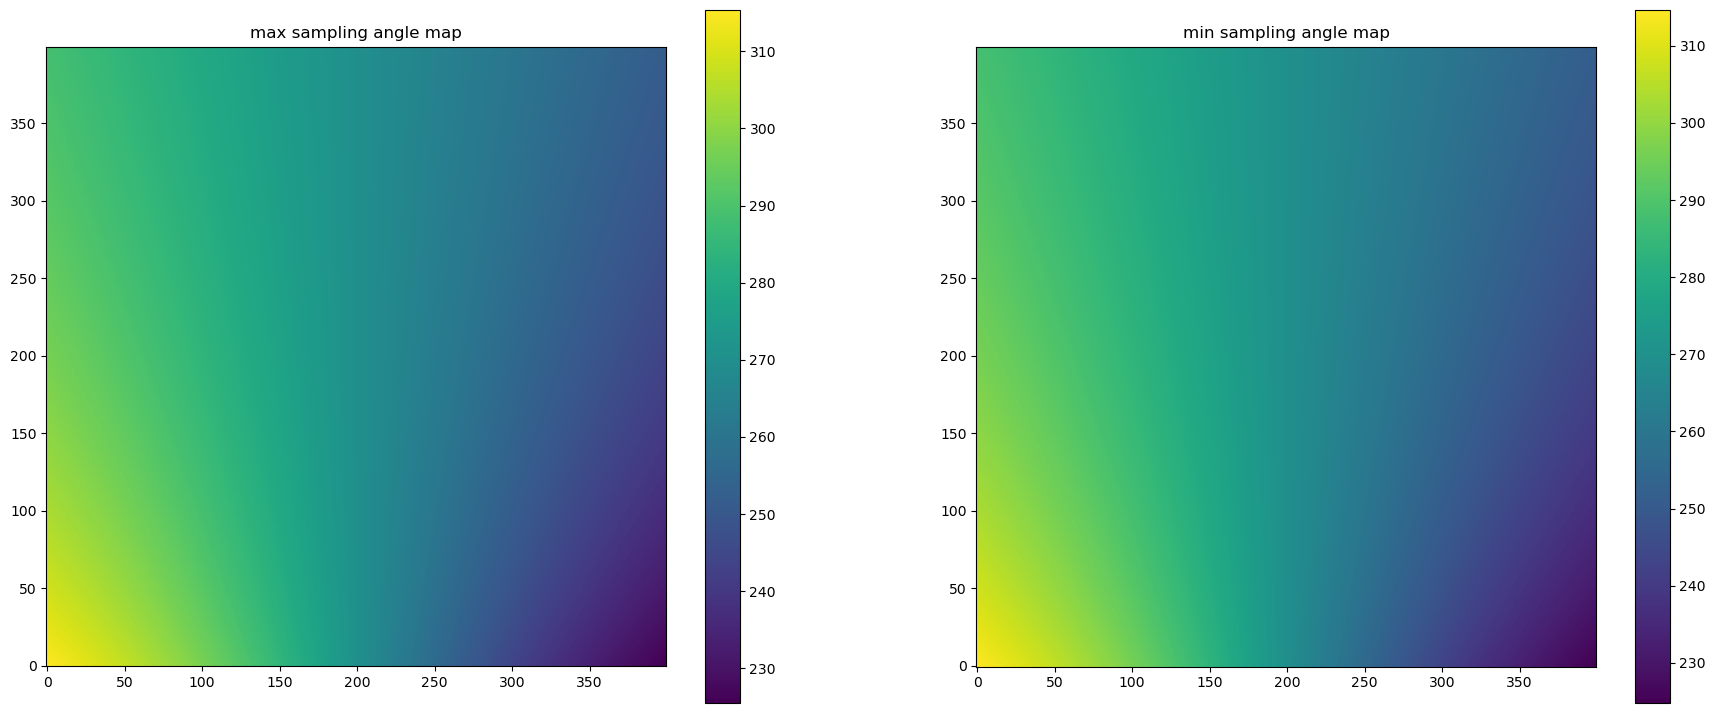

In [103]:
fig, axs = plt.subplots(1,2,figsize=(22,9))
axs[0].set_title("max sampling angle map")
fig.colorbar(axs[0].imshow(max_angle,origin='lower',interpolation='None'))
axs[1].set_title("min sampling angle map")
fig.colorbar(axs[1].imshow(min_angle,origin='lower',interpolation='None'))
del fig, axs

### Max and Min sampling angle map of FOV pixels for all dummy detectors

In [104]:
N_angle = 36
N_tc = 39
step_tc = 10
dims=np.array((400,400))
max_sa_mat= np.empty((N_angle, N_tc, dims[0],dims[1]))
min_sa_mat= np.empty((N_angle, N_tc, dims[0],dims[1]))
for angle_idx in np.arange(N_angle):
    angle = angle_idx*360/N_angle
    # print(angle)
    for tc_idx in np.arange(N_tc):
        tc=(tc_idx+1)*step_tc
        max_angle, min_angle = sampling_angle(dims,5,15,angle,tc)
        max_sa_mat[angle_idx,tc_idx]=max_angle
        min_sa_mat[angle_idx,tc_idx]=min_angle

### Plot the max - min

In [105]:
diff_sa_mat = max_sa_mat - min_sa_mat

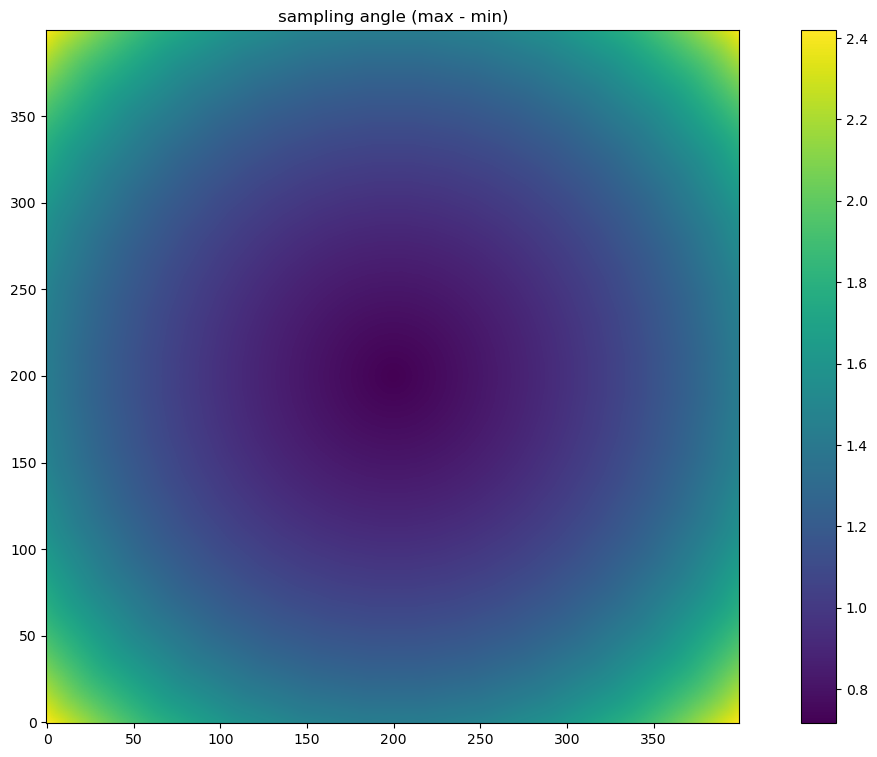

In [106]:
fig, ax = plt.subplots(figsize=(16,9))
ax.set_title("sampling angle (max - min)")
fig.colorbar(ax.imshow(np.max(diff_sa_mat,axis=(0,1)),origin='lower'))
del fig, ax